#Importing the Necessary Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#Loading Content and Style Image

In [ ]:
content_img = Image.open('/content/content_img.jpg').convert('RGB')
style_img = Image.open('/content/IMAGE_9.jpg').convert('RGB')

#Image Preprocessing

In [ ]:
def preprocess_content_img(image):
  image = img_to_array(image)
  height, width, _ = image.shape
  aspect_ratio = width / height
  new_width = int(aspect_ratio * 480)
  image = tf.image.resize(image, (480, new_width))
  image = image/255.
  return image

In [ ]:
def preprocess_sytle_img(image):
  image = img_to_array(image)
  image = image/255.
  return image

In [ ]:
content_img = preprocess_content_img(content_img)
style_img = preprocess_sytle_img(style_img)

#Visualize Content and Style Image

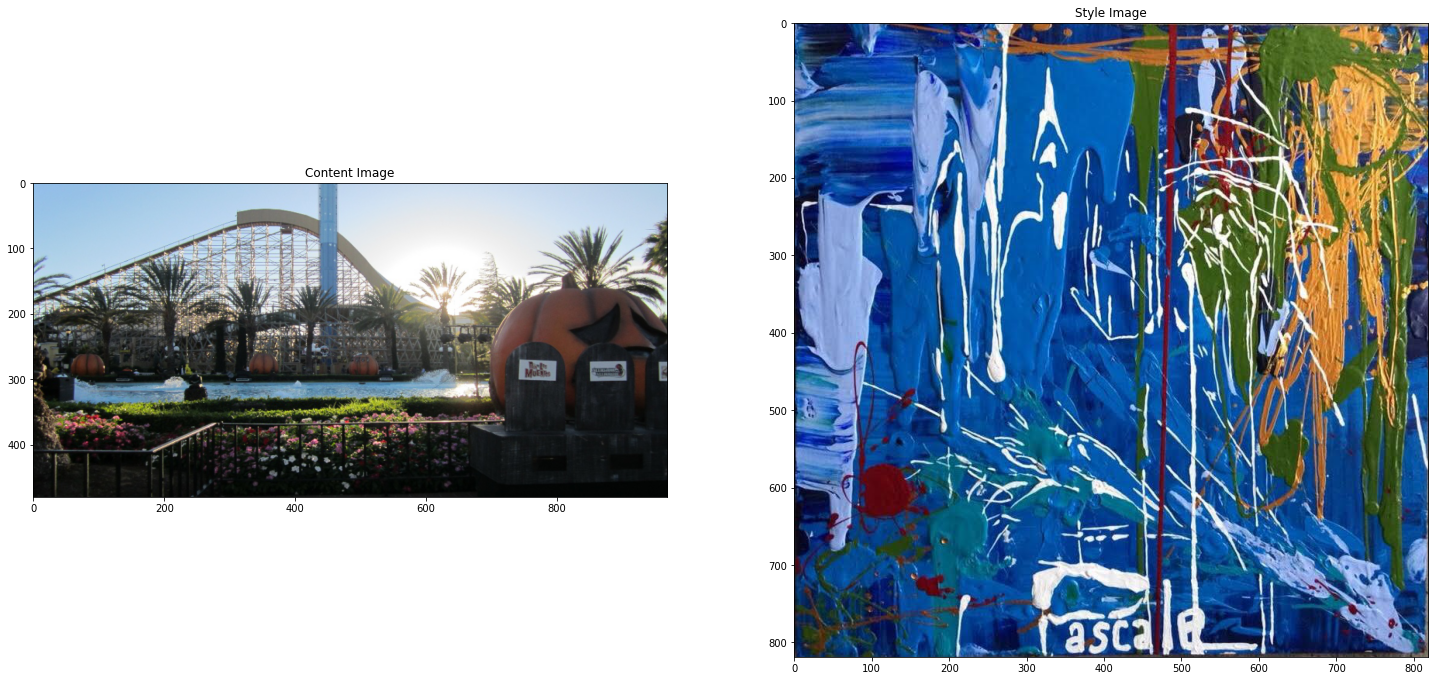

In [ ]:
def plot_images(images, titles=None):
  num_images = len(images)
  fig, axes = plt.subplots(1, num_images, figsize=(25, 25))
  for i, (image, ax) in enumerate(zip(images, axes)):
    if len(image.shape) > 3:
      image = tf.squeeze(image, axis=0)
    ax.imshow(image)
    if titles is not None and i < len(titles):
      ax.set_title(titles[i])

  plt.show()
plot_images([content_img, style_img], ['Content Image', 'Style Image'])

#Convert Tensor to Image

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor.numpy()
  tensor = (tensor * 255).astype(np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

#Define the Model

In [ ]:
base_model_effnet = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
base_model_effnet.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_6 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_6[0][0]']            
 )                              3)                                                   

In [ ]:
style_layer_names = ['block1a_activation',
                     'block2a_activation',
                     'block2b_activation',
                     'block3a_activation',
                     'block3b_activation',
                     'block4a_activation',
                     'block4b_activation',
                    ]
num_style_layers = len(style_layer_names)

content_layer_name = ['block5a_activation']

In [ ]:
def get_model(base_model, style_layer_names, content_layer_names):
    outputs = []
    for name in style_layer_names:
        outputs.append(base_model.get_layer(name).output)
    for name in content_layer_names:
        outputs.append(base_model.get_layer(name).output)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    model.trainable = False
    return model
model = get_model(base_model_effnet, style_layer_names, content_layer_name)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

#Computing the Gram Matrix

In [ ]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(tf.shape(input_tensor)[0]*tf.shape(input_tensor)[1]*tf.shape(input_tensor)[2], tf.float32)

#Extracting Image Style and Content

In [ ]:
def extract_style_content(img_tensor, model):
    preprocessed_img = tf.keras.applications.efficientnet.preprocess_input(img_tensor*255.)
    features = model(preprocessed_img)
    style_features = [gram_matrix(feature) for feature in features[:len(style_layer_names)]]
    content_features = features[-1]
    return style_features, content_features

#Loss Function

In [ ]:
def c_loss(style_outputs, content_output, target_style_outputs, target_content_output):
    style_weight = 10 #@param {type:"slider", min:0, max:10, step:1}
    content_weight = 0.7 #@param {type:"slider", min:-1, max:1, step:0.01}
    style_losses = []
    for i, output in enumerate(style_outputs):
        target_output = target_style_outputs[i]
        style_losses.append(tf.reduce_mean(tf.square(output - target_output)))
    style_loss = tf.reduce_mean(style_losses)
    content_loss = tf.reduce_mean(tf.square(content_output - target_content_output))
    total_loss = style_weight*style_loss + content_weight*content_loss
    return total_loss

#Computing Target Content and Style Outputs

In [ ]:
content_img_tensor = tf.expand_dims(tf.constant(content_img), axis=0)
_, target_content_output = extract_style_content(content_img_tensor, model)

style_img_tensor = tf.expand_dims(tf.constant(style_img), axis=0)
target_style_outputs, _ = extract_style_content(style_img_tensor, model)

#Function for Single Step Through the Training Loop

In [ ]:
@tf.function()
def train_step(img, model, optimizer, target_style_outputs, target_content_output):
    with tf.GradientTape() as tape:
        style_outputs, content_output = extract_style_content(img, model)
        loss = c_loss(style_outputs, content_output, target_style_outputs, target_content_output)

    grads = tape.gradient(loss, img)
    optimizer.apply_gradients([(grads, img)])
    img.assign(tf.clip_by_value(img, 0.0, 1.0))

#Initializing the Input Image Which will be Updated During Training

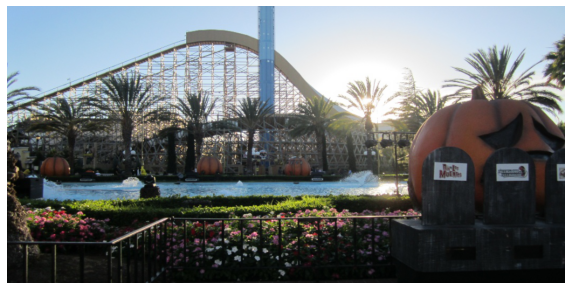

In [ ]:
image  = np.clip(content_img, 0., 1.)
image  = np.expand_dims(image , axis=0)
image  = tf.Variable(image )
plt.figure(figsize=(10,10))
plt.imshow(image.numpy()[0])
plt.axis('off')
plt.show()

#Training the Model

In [ ]:
num_epochs = 5
steps_per_epoch = 100

start = time.time()
for epoch in range(num_epochs):
  print("Epoch {}/{}".format(epoch+1, num_epochs))
  for step in range(steps_per_epoch):
    train_step(image, model, optimizer, target_style_outputs, target_content_output)

  plt.figure(figsize=(12,10))
  stylized_image = tensor_to_image(image)
  plt.imshow(stylized_image)
  plt.axis('off')
  plt.title("Epoch {}".format(epoch+1))
  plt.show()
end = time.time()
print("Total training time: {:.1f} seconds".format(end-start))

Output hidden; open in https://colab.research.google.com to view.

#Visualize the Content, Style and Stylized Image

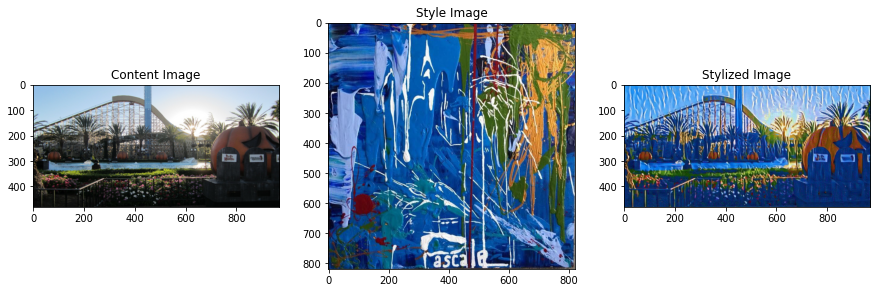

In [ ]:
def plot_images(images, titles=None):
  num_images = len(images)

  fig, axes = plt.subplots(1, num_images, figsize=(15, 20))
  for i, (image, ax) in enumerate(zip(images, axes)):
    if isinstance(image, Image.Image):
      image = np.array(image)
    if len(image.shape) > 3:
      image = tf.squeeze(image, axis=0)
    ax.imshow(image)
    if titles is not None and i < len(titles):
      ax.set_title(titles[i])
  plt.show()

generated_img = tensor_to_image(image)
plot_images([content_img, style_img, generated_img], ['Content Image', 'Style Image', 'Stylized Image'])

#Save the Stylized Image

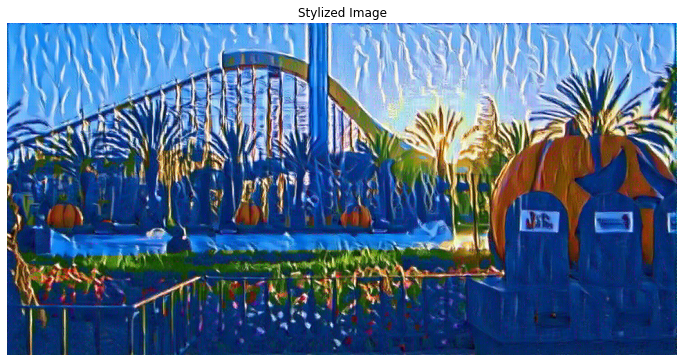

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(generated_img)
plt.title('Stylized Image')
plt.axis('off')
plt.show()
generated_img.save('Style-transfer-image.jpeg')